<a href="https://colab.research.google.com/github/shauryanegi/-Network-Intrusion-Detection-System/blob/master/shauryanegi17_gmail_com_Walmart_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the important packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
from datetime import datetime
from datetime import timedelta
%matplotlib inline
import math
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn import metrics

print(pd.__version__)
print(np.__version__)
print(sns.__version__)

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

1.0.3
1.18.4
0.10.1
TensorFlow Version: 2.2.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: No GPU found. Please ensure you have installed TensorFlow correctly


## Create UDF's

In [0]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([
        x.count(),
        x.isnull().sum(),
        x.sum(),
        x.mean(),
        x.median(),
        x.std(),
        x.var(),
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.50),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR',
                         'MIN', 'P1', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90',
                         'P95', 'P99', 'MAX'
                     ])

In [0]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [0]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats='mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x 

In [0]:
#An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df

In [0]:
# create user defined function to create the freq plots
def fn_countplot(pd_series):
    plt.figure(figsize=(5, 3))
    sns.countplot(y=pd_series)
    print('This is a freq chart for ' + pd_series.name)
    plt.show()
    return

## Importing the Datasets

In [0]:
features = pd.read_csv('features.csv')
    #"C:/Data Sets/(Class 21-Python - Case Study)/2. Walmart Store Sales Forecasting/data/features.csv"
#)
stores = pd.read_csv('stores.csv')
   # "C:/Data Sets/(Class 21-Python - Case Study)/2. Walmart Store Sales Forecasting/data/stores.csv"
#)
train = pd.read_csv('train.csv')
   # "C:/Data Sets/(Class 21-Python - Case Study)/2. Walmart Store Sales Forecasting/data/train.csv"
#)
test = pd.read_csv('test.csv')
    #"C:/Data Sets/(Class 21-Python - Case Study)/2. Walmart Store Sales Forecasting/data/test.csv"
#)

print('Dimensions of the Training set:', train.shape)
print('Dimensions of the Test set:', test.shape)

Dimensions of the Training set: (421570, 5)
Dimensions of the Test set: (115064, 4)


In [0]:
features.head() #First 5 elements for data insepction

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [0]:
stores.head() #First 5 elements for data insepction

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [0]:
train.head() #First 5 elements for data insepction

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [0]:
test.head() #First 5 elements for data insepction

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Data Inspection

In [0]:
features.info()  #We have some missing values in the MarkDown columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [0]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [0]:
#We can see that the store and date is same in features and train table we can merge this tables and we are performing inner join.
data = pd.merge(train,
                features,
                on=['Store', 'Date'],
                how='inner',
                suffixes=('_train', '_features'))

In [0]:
#We can merge data and stores as Store is a common variable. We will perform inner join.
data1 = pd.merge(data, stores, on=['Store'], how='inner')

In [0]:
data

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False


In [0]:
data1

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221


In [0]:
#We have consolidated all the files in the train data. We will have to do the same on test data.
data_test = pd.merge(test,
                features,
                on=['Store', 'Date'],
                how='inner',
                suffixes=('_test', '_features'))

In [0]:
data1_test = pd.merge(data_test, stores, on = ['Store'], how = 'inner')

In [0]:
data1.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_train',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_features',
       'Type', 'Size'],
      dtype='object')

In [0]:
data1_test.columns  #Weekly sales is not given because this is our test data and we have to predict the Weekly sales as that is our case study.

Index(['Store', 'Dept', 'Date', 'IsHoliday_test', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday_features', 'Type', 'Size'],
      dtype='object')

In [0]:
#Pandas Profiling to analyze the data
#!pip install pandas_profiling 

#report = pandas_profiling.ProfileReport(
 #   data1, minimal=True
#)  #Minimal features because Pandas Profiling was taking a lot of time to run.
#report.to_file(
 #   output_file=
  #  "C:/Data Sets/(Class 21-Python - Case Study)/2. Walmart Store Sales Forecasting/Pandasprofling.html"
#)
#report

## Data Visualisation

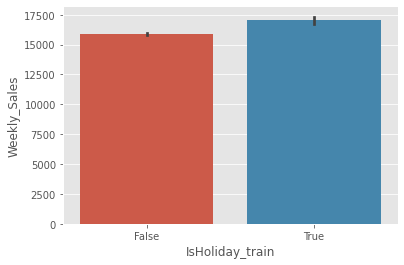

In [0]:
holiday = data1['Weekly_Sales'].loc[data1['IsHoliday_train'] ==
                                    True]  # Weekly Sales in Holidays
non_holiday = data1['Weekly_Sales'].loc[data1['IsHoliday_train'] ==
                                        False]  #Weekly Sales in Non-holidays.
sns.barplot(x='IsHoliday_train', y='Weekly_Sales', data=data1)

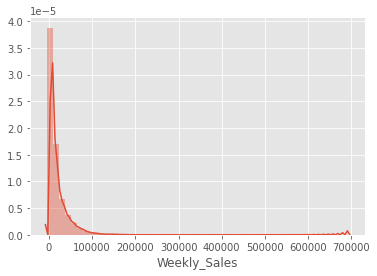

3.262008185465662

In [0]:
# Note: good practice is to take the log of the data plus 1, bcoz we don't have log of zero defined
# In this data its not required as sales are always greater than zero

sns.distplot(data1.Weekly_Sales)
plt.show()

data1.Weekly_Sales.skew()

#The data is heavily skewed so Linear Regression will not be effective in this model. We will check it while running the model.

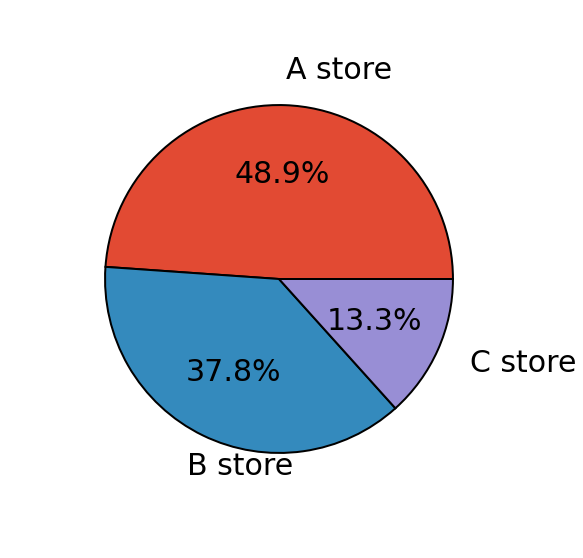

In [0]:
sorted_type = stores.groupby('Type')
plt.style.use('ggplot')
labels = ['A store', 'B store', 'C store']
sizes = sorted_type.describe()['Size'].round(1)
sizes = [(22 / (17 + 6 + 22)) * 100, (17 / (17 + 6 + 22)) * 100,
         (6 / (17 + 6 + 22)) * 100]  # convert to the proportion
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
wprops = {'edgecolor': 'black', 'linewidth': 2}
tprops = {'fontsize': 30}
axes.pie(sizes,
         labels=labels,
         explode=(0.0, 0, 0),
         autopct='%1.1f%%',
         pctdistance=0.6,
         labeldistance=1.2,
         wedgeprops=wprops,
         textprops=tprops,
         radius=0.8,
         center=(0.5, 0.5))
plt.show()

#Distribution of stores by store type

## Data Processing on Train and Test Data

In [0]:
data1.info()   #We have some null values on Markdown variables which we will deal with. The dates here are in object type. We will work on those.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Store               421570 non-null  int64  
 1   Dept                421570 non-null  int64  
 2   Date                421570 non-null  object 
 3   Weekly_Sales        421570 non-null  float64
 4   IsHoliday_train     421570 non-null  bool   
 5   Temperature         421570 non-null  float64
 6   Fuel_Price          421570 non-null  float64
 7   MarkDown1           150681 non-null  float64
 8   MarkDown2           111248 non-null  float64
 9   MarkDown3           137091 non-null  float64
 10  MarkDown4           134967 non-null  float64
 11  MarkDown5           151432 non-null  float64
 12  CPI                 421570 non-null  float64
 13  Unemployment        421570 non-null  float64
 14  IsHoliday_features  421570 non-null  bool   
 15  Type                421570 non-nul

In [0]:
data1_test.info() #We have some null values on Markdown variables which we will deal with. The dates here are in object type. We will work on those.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Store               115064 non-null  int64  
 1   Dept                115064 non-null  int64  
 2   Date                115064 non-null  object 
 3   IsHoliday_test      115064 non-null  bool   
 4   Temperature         115064 non-null  float64
 5   Fuel_Price          115064 non-null  float64
 6   MarkDown1           114915 non-null  float64
 7   MarkDown2           86437 non-null   float64
 8   MarkDown3           105235 non-null  float64
 9   MarkDown4           102176 non-null  float64
 10  MarkDown5           115064 non-null  float64
 11  CPI                 76902 non-null   float64
 12  Unemployment        76902 non-null   float64
 13  IsHoliday_features  115064 non-null  bool   
 14  Type                115064 non-null  object 
 15  Size                115064 non-nul

In [0]:
data1['Date'] = pd.to_datetime(
    data1.Date)  #Converting Date from object to DateTime. #Highly cardinal.
data1['Year'] = data1.Date.dt.year  #Year column in dataset
data1['Month'] = data1.Date.dt.month  #Month column in dataset
data1['Week'] = data1.Date.dt.week  #Week column in dataset

#Dropping the date column
data1.drop(columns = ['Date'], inplace = True)

In [0]:
data1_test['Date'] = pd.to_datetime(data1_test.Date)  #Converting Date from object to DateTime. #Highly cardinal.
data1_test['Year'] = data1_test.Date.dt.year  #Year column in dataset
data1_test['Month']= data1_test.Date.dt.month #Month column in dataset
data1_test['Week']= data1_test.Date.dt.week   #Week column in dataset

#Dropping the date column
data1_test.drop(columns = ['Date'], inplace = True)

In [0]:
data1['Temperature'] =  (data1['Temperature']-32) * 5/9
 #Temparature is in Fahrenheit. Converted into Celsius as it is more prominent here and for better understanding.

In [0]:
data1_test['Temperature'] =  (data1['Temperature']-32) * 5/9
 #Temparature is in Fahrenheit. Converted into Celsius as it is more prominent here and for better understanding.

In [0]:
data1.rename(columns = {'Weekly_Sales': 'Weeklysales'}, inplace = True) #Renaming the column name for easier syntax. This column is only in train data.
data1.head()

,Store,Dept,Weeklysales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features,Type,Size,Year,Month,Week
0,1,1,24924.50,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5
1,1,2,50605.27,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5
2,1,3,13740.12,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5
3,1,4,39954.04,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5
4,1,5,32229.38,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5


In [0]:
#Grouping sales per year for data understanding.

data1_pivot = data1.pivot_table(values = 'Weeklysales', index = 'Store', columns = 'Year', aggfunc = np.sum, margins = True ).T
data1_pivot.round()

Store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,All
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,73278832.0,95277864.0,18745419.0,95680471.0,14836031.0,76912321.0,25568078.0,43204475.0,25129220.0,94472202.0,65255138.0,48370384.0,95272735.0,105462242.0,32023528.0,24728633.0,41104920.0,55978417.0,72580529.0,101733081.0,37631108.0,50865280.0,67709105.0,66890648.0,35136268.0,48390698.0,90013177.0,64778765.0,26946827.0,21739087.0,65560273.0,55190937.0,12766834.0,46150417.0,52195971.0,21153126.0,24508470.0,16587795.0,65782276.0,46357360.0,57738221.0,25498090.0,31537006.0,13607519.0,38536343.0,2.288886e+09
2011,80921919.0,98607881.0,20816877.0,111092293.0,16470820.0,80528763.0,30662641.0,47512786.0,28685970.0,98916895.0,70523583.0,52582001.0,104537513.0,106096271.0,32282625.0,27421367.0,46391840.0,54217740.0,74841900.0,109837002.0,40234884.0,53554712.0,72273534.0,69938977.0,36434406.0,52049252.0,91922684.0,69156009.0,27950345.0,22182148.0,74169226.0,61347193.0,12957837.0,50360182.0,44086979.0,18972619.0,27081496.0,19940758.0,75777603.0,50340543.0,66715874.0,29117303.0,32053195.0,15498195.0,41135368.0,2.448200e+09
2012,68202058.0,81496695.0,18024440.0,92771189.0,14168838.0,66315047.0,25367556.0,39233920.0,23974030.0,78228617.0,58184066.0,43334846.0,86707455.0,77441398.0,24827531.0,22102425.0,40285379.0,44918577.0,59212433.0,89827709.0,30251887.0,42655656.0,58767979.0,57186396.0,29490506.0,42976444.0,71920056.0,55328907.0,22244382.0,18795650.0,59884407.0,50281116.0,11435551.0,41739164.0,35237723.0,13286471.0,22612775.0,18631073.0,65885663.0,41172407.0,56887840.0,24950360.0,26975234.0,14187374.0,32723630.0,2.000133e+09
All,222402809.0,275382441.0,57586735.0,299543953.0,45475689.0,223756131.0,81598275.0,129951181.0,77789219.0,271617714.0,193962787.0,144287230.0,286517704.0,288999911.0,89133684.0,74252425.0,127782139.0,155114734.0,206634862.0,301397792.0,108117879.0,147075649.0,198750618.0,194016021.0,101061179.0,143416394.0,253855917.0,189263681.0,77141554.0,62716885.0,199613905.0,166819246.0,37160222.0,138249763.0,131520672.0,53412215.0,74202740.0,55159626.0,207445542.0,137870310.0,181341935.0,79565752.0,90565435.0,43293088.0,112395341.0,6.737219e+09


In [0]:
#Dealing with negative values. Markdown 2 and 3 have negative values. Changing it to NaN
#data1.MarkDown2[data1.MarkDown2 < 0] == np.NaN
#data1.MarkDown3[data1.MarkDown3 < 0] == np.NaN

data1.MarkDown2 = np.where(data1.MarkDown2 < 0, np.NaN, data1.MarkDown2)
data1.MarkDown3 = np.where(data1.MarkDown3 < 0, np.NaN,data1.MarkDown3)


In [0]:
#Executing on Test Data
data1_test.MarkDown1 = np.where(data1_test.MarkDown1 < 0, np.NaN, data1_test.MarkDown1)
data1_test.MarkDown2 = np.where(data1_test.MarkDown3 < 0, np.NaN,data1_test.MarkDown2)
data1_test.MarkDown3 = np.where(data1_test.MarkDown3 < 0, np.NaN,data1_test.MarkDown3)
data1_test.MarkDown4 = np.where(data1_test.MarkDown3 < 0, np.NaN,data1_test.MarkDown4)
data1_test.MarkDown5 = np.where(data1_test.MarkDown3 < 0, np.NaN,data1_test.MarkDown5)

## Lagged Sales on Train and Test Data

In [0]:
#Lagged Sales on Train and Test Data

#data1['Lag_Sales_1'] = data1.Weeklysales.shift(1)
#data1['Lag_Sales_2'] = data1.Weeklysales.shift(2)

data1['Temp_Lag_1'] = data1.Temperature.shift(1)
data1['Temp_Lag_2'] = data1.Temperature.shift(2)

data1['Fuel_Lag_1'] = data1.Fuel_Price.shift(1)
data1['Fuel_Lag_2'] = data1.Fuel_Price.shift(2)

#data1_test['Lag_Sales_1'] = data1_test.Weeklysales.shift(1)
#data1_test['Lag_Sales_2'] = data1_test.Weeklysales.shift(2)

data1_test['Temp_Lag_1'] = data1_test.Temperature.shift(1)
data1_test['Temp_Lag_2'] = data1_test.Temperature.shift(2)

data1_test['Fuel_Lag_1'] = data1_test.Fuel_Price.shift(1)
data1_test['Fuel_Lag_2'] = data1_test.Fuel_Price.shift(2)

## Separating the categorical and continous values

In [0]:
#Separating the categorical and continous values

data1_cont = data1.select_dtypes(['int64','float64'])
data1_cat = data1.select_dtypes(['object','bool'])

In [0]:
#Separating the categorical and continous values

data1_test_cont = data1_test.select_dtypes(['int64','float64'])
data1_test_cat = data1_test.select_dtypes(['object','bool'])

In [0]:
#Summary of all the variables
data1_cont.apply(continuous_var_summary)

,Store,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Week,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2
N,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,1.506810e+05,1.099370e+05,1.368340e+05,1.349670e+05,1.514320e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215690e+05,4.215680e+05,4.215690e+05,4.215680e+05
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.708890e+05,3.116330e+05,2.847360e+05,2.866030e+05,2.701380e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
SUM,9.359084e+06,1.865882e+07,6.737219e+09,6.578848e+06,1.416908e+06,1.091898e+09,3.710112e+08,1.973339e+08,4.566161e+08,7.009750e+08,7.217360e+07,3.355819e+06,5.764039e+10,8.477640e+08,2.718920e+06,1.088779e+07,6.578833e+06,6.578818e+06,1.416904e+06,1.416900e+06
MEAN,2.220055e+01,4.426032e+01,1.598126e+04,1.560559e+01,3.361027e+00,7.246420e+03,3.374762e+03,1.442141e+03,3.383168e+03,4.628975e+03,1.712019e+02,7.960289e+00,1.367279e+05,2.010969e+03,6.449510e+00,2.582676e+01,1.560559e+01,1.560559e+01,3.361025e+00,3.361024e+00
MEDIAN,2.200000e+01,3.700000e+01,7.612030e+03,1.671667e+01,3.452000e+00,5.347450e+03,2.008200e+02,2.473000e+01,1.481310e+03,3.359450e+03,1.823188e+02,7.866000e+00,1.401670e+05,2.011000e+03,6.000000e+00,2.600000e+01,1.671667e+01,1.671667e+01,3.452000e+00,3.452000e+00
STD,1.278530e+01,3.049205e+01,2.271118e+04,1.024885e+01,4.585145e-01,8.291221e+03,9.524512e+03,9.631906e+03,6.292384e+03,5.962887e+03,3.915928e+01,1.863296e+00,6.098058e+04,7.968760e-01,3.243217e+00,1.415189e+01,1.024886e+01,1.024887e+01,4.585144e-01,4.585142e-01
VAR,1.634638e+02,9.297654e+02,5.157979e+08,1.050389e+02,2.102356e-01,6.874435e+07,9.071632e+07,9.277362e+07,3.959410e+07,3.555603e+07,1.533449e+03,3.471872e+00,3.718632e+09,6.350114e-01,1.051846e+01,2.002759e+02,1.050392e+02,1.050394e+02,2.102354e-01,2.102353e-01
MIN,1.000000e+00,1.000000e+00,-4.988940e+03,-1.892222e+01,2.472000e+00,2.700000e-01,0.000000e+00,0.000000e+00,2.200000e-01,1.351600e+02,1.260640e+02,3.879000e+00,3.487500e+04,2.010000e+03,1.000000e+00,1.000000e+00,-1.892222e+01,-1.892222e+01,2.472000e+00,2.472000e+00
P1,1.000000e+00,1.000000e+00,5.000000e+00,-7.611111e+00,2.565000e+00,1.776000e+01,2.400000e-01,1.500000e-01,3.970000e+00,3.519700e+02,1.261119e+02,4.156000e+00,3.487500e+04,2.010000e+03,1.000000e+00,1.000000e+00,-7.611111e+00,-7.611111e+00,2.565000e+00,2.565000e+00
P5,3.000000e+00,4.000000e+00,5.997450e+01,-2.605556e+00,2.653000e+00,1.491900e+02,3.000000e+00,6.800000e-01,2.876000e+01,7.155200e+02,1.264963e+02,5.326000e+00,3.969000e+04,2.010000e+03,1.000000e+00,4.000000e+00,-2.605556e+00,-2.605556e+00,2.653000e+00,2.653000e+00


In [0]:
data1_cat.apply(categorical_var_summary)

,IsHoliday_train,IsHoliday_features,Type
N,421570,421570,421570
NMISS,0,0,0
MODE,False,False,A
FREQ,391909,391909,215478
PERCENT,92.96,92.96,51.11


## Missing Value Imputation

In [0]:
#Missing Value Imputation
data1_cont = data1_cont.apply(missing_imputation)
data1_test_cont = data1_test_cont.apply(missing_imputation)

In [0]:
data1_cat = data1_cat.apply(missing_imputation)
data1_test_cat = data1_test_cat.apply(missing_imputation)

In [0]:
data1_cont.apply(continuous_var_summary) #We find that there are outliers in the data.

,Store,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Week,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2
N,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SUM,9.359084e+06,1.865882e+07,6.737219e+09,6.578848e+06,1.416908e+06,3.054873e+09,1.422698e+09,6.079634e+08,1.426242e+09,1.951437e+09,7.217360e+07,3.355819e+06,5.764039e+10,8.477640e+08,2.718920e+06,1.088779e+07,6.578849e+06,6.578849e+06,1.416907e+06,1.416907e+06
MEAN,2.220055e+01,4.426032e+01,1.598126e+04,1.560559e+01,3.361027e+00,7.246420e+03,3.374762e+03,1.442141e+03,3.383168e+03,4.628975e+03,1.712019e+02,7.960289e+00,1.367279e+05,2.010969e+03,6.449510e+00,2.582676e+01,1.560559e+01,1.560559e+01,3.361025e+00,3.361024e+00
MEDIAN,2.200000e+01,3.700000e+01,7.612030e+03,1.671667e+01,3.452000e+00,7.246420e+03,3.374762e+03,1.442141e+03,3.383168e+03,4.628975e+03,1.823188e+02,7.866000e+00,1.401670e+05,2.011000e+03,6.000000e+00,2.600000e+01,1.671667e+01,1.671667e+01,3.452000e+00,3.452000e+00
STD,1.278530e+01,3.049205e+01,2.271118e+04,1.024885e+01,4.585145e-01,4.956921e+03,4.863830e+03,5.487485e+03,3.560353e+03,3.573795e+03,3.915928e+01,1.863296e+00,6.098058e+04,7.968760e-01,3.243217e+00,1.415189e+01,1.024885e+01,1.024885e+01,4.585138e-01,4.585131e-01
VAR,1.634638e+02,9.297654e+02,5.157979e+08,1.050389e+02,2.102356e-01,2.457106e+07,2.365684e+07,3.011249e+07,1.267611e+07,1.277201e+07,1.533449e+03,3.471872e+00,3.718632e+09,6.350114e-01,1.051846e+01,2.002759e+02,1.050389e+02,1.050389e+02,2.102349e-01,2.102343e-01
MIN,1.000000e+00,1.000000e+00,-4.988940e+03,-1.892222e+01,2.472000e+00,2.700000e-01,0.000000e+00,0.000000e+00,2.200000e-01,1.351600e+02,1.260640e+02,3.879000e+00,3.487500e+04,2.010000e+03,1.000000e+00,1.000000e+00,-1.892222e+01,-1.892222e+01,2.472000e+00,2.472000e+00
P1,1.000000e+00,1.000000e+00,5.000000e+00,-7.611111e+00,2.565000e+00,5.834000e+01,1.910000e+00,4.000000e-01,1.433000e+01,5.480200e+02,1.261119e+02,4.156000e+00,3.487500e+04,2.010000e+03,1.000000e+00,1.000000e+00,-7.611111e+00,-7.611111e+00,2.565000e+00,2.565000e+00
P5,3.000000e+00,4.000000e+00,5.997450e+01,-2.605556e+00,2.653000e+00,7.093200e+02,2.600000e+01,2.770000e+00,2.735300e+02,1.288810e+03,1.264963e+02,5.326000e+00,3.969000e+04,2.010000e+03,1.000000e+00,4.000000e+00,-2.605556e+00,-2.605556e+00,2.653000e+00,2.653000e+00


## Handling Outliers

In [0]:
data1_cont = data1_cont.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))
data1_test_cont = data1_test_cont.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [0]:
data1_cont.apply(continuous_var_summary) #We find that we removed outliers in the data.

,Store,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Week,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2
N,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SUM,9.359084e+06,1.865796e+07,6.599483e+09,6.583074e+06,1.416587e+06,2.996637e+09,1.331975e+09,4.343137e+08,1.363278e+09,1.893363e+09,7.217089e+07,3.355685e+06,5.764039e+10,8.477640e+08,2.718920e+06,1.088779e+07,6.583075e+06,6.583076e+06,1.416586e+06,1.416586e+06
MEAN,2.220055e+01,4.425827e+01,1.565454e+04,1.561561e+01,3.360265e+00,7.108278e+03,3.159559e+03,1.030229e+03,3.233813e+03,4.491218e+03,1.711955e+02,7.959971e+00,1.367279e+05,2.010969e+03,6.449510e+00,2.582676e+01,1.561562e+01,1.561562e+01,3.360263e+00,3.360262e+00
MEDIAN,2.200000e+01,3.700000e+01,7.612030e+03,1.671667e+01,3.452000e+00,7.246420e+03,3.374762e+03,1.442141e+03,3.383168e+03,4.628975e+03,1.823188e+02,7.866000e+00,1.401670e+05,2.011000e+03,6.000000e+00,2.600000e+01,1.671667e+01,1.671667e+01,3.452000e+00,3.452000e+00
STD,1.278530e+01,3.048842e+01,2.078167e+04,1.016516e+01,4.562054e-01,3.885739e+03,2.685404e+03,6.410116e+02,2.202155e+03,2.016136e+03,3.914964e+01,1.859419e+00,6.098058e+04,7.968760e-01,3.243217e+00,1.415189e+01,1.016516e+01,1.016516e+01,4.562047e-01,4.562040e-01
VAR,1.634638e+02,9.295435e+02,4.318778e+08,1.033305e+02,2.081234e-01,1.509897e+07,7.211396e+06,4.108959e+05,4.849485e+06,4.064806e+06,1.532695e+03,3.457438e+00,3.718632e+09,6.350114e-01,1.051846e+01,2.002759e+02,1.033305e+02,1.033305e+02,2.081227e-01,2.081221e-01
MIN,1.000000e+00,1.000000e+00,5.000000e+00,-7.611111e+00,2.565000e+00,5.834000e+01,1.910000e+00,4.000000e-01,1.433000e+01,5.480200e+02,1.261119e+02,4.156000e+00,3.487500e+04,2.010000e+03,1.000000e+00,1.000000e+00,-7.611111e+00,-7.611111e+00,2.565000e+00,2.565000e+00
P1,1.000000e+00,1.000000e+00,5.000000e+00,-7.611111e+00,2.565000e+00,5.834000e+01,1.910000e+00,4.000000e-01,1.433000e+01,5.480200e+02,1.261119e+02,4.156000e+00,3.487500e+04,2.010000e+03,1.000000e+00,1.000000e+00,-7.611111e+00,-7.611111e+00,2.565000e+00,2.565000e+00
P5,3.000000e+00,4.000000e+00,5.997450e+01,-2.605556e+00,2.653000e+00,7.093200e+02,2.600000e+01,2.770000e+00,2.735300e+02,1.288810e+03,1.264963e+02,5.326000e+00,3.969000e+04,2.010000e+03,1.000000e+00,4.000000e+00,-2.605556e+00,-2.605556e+00,2.653000e+00,2.653000e+00


In [0]:
data1_cont.head()

,Store,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Week,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2
0,1,1,24924.50,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5,15.605590,15.605591,3.361025,3.361024
1,1,2,50605.27,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5,5.727778,15.605591,2.572000,3.361024
2,1,3,13740.12,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5,5.727778,5.727778,2.572000,2.572000
3,1,4,39954.04,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5,5.727778,5.727778,2.572000,2.572000
4,1,5,32229.38,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5,5.727778,5.727778,2.572000,2.572000


In [0]:
data1_cat.head()

,IsHoliday_train,IsHoliday_features,Type
0,False,False,A
1,False,False,A
2,False,False,A
3,False,False,A
4,False,False,A


## Creating Dummy Variables

In [0]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df


cat_dummies = ['IsHoliday_train', 'IsHoliday_features', 'Type']

for c_feature in [cat_dummies]:
    data1_cat[c_feature] = data1_cat[c_feature].astype('category')
    data1_cat = create_dummies(data1_cat, c_feature)

for c_feature in ['Week','Store']:
    data1_cont[c_feature] = data1_cont[c_feature].astype('float64')
    data1_cont = create_dummies(data1_cont, c_feature)

In [0]:
#Dummy variables for test data.

cattest_dummies = ['IsHoliday_test', 'IsHoliday_features', 'Type']

for c_feature in [cattest_dummies]:
    data1_test_cat[c_feature] = data1_test_cat[c_feature].astype('category')
    data1_test_cat = create_dummies(data1_test_cat, c_feature)

for c_feature in ['Week','Store']:
    data1_test_cont[c_feature] = data1_test_cont[c_feature].astype('float64')
    data1_test_cont = create_dummies(data1_test_cont, c_feature)

## Final Data for Analysis

In [0]:
data_train = pd.concat([data1_cont, data1_cat], axis = 1)
data_test = pd.concat([data1_test_cont, data1_test_cat], axis = 1)

In [0]:
data_train.head()

,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2,Week_2.0,Week_3.0,Week_4.0,Week_5.0,Week_6.0,Week_7.0,Week_8.0,Week_9.0,Week_10.0,Week_11.0,Week_12.0,Week_13.0,Week_14.0,Week_15.0,Week_16.0,Week_17.0,Week_18.0,Week_19.0,Week_20.0,Week_21.0,Week_22.0,Week_23.0,...,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Store_21.0,Store_22.0,Store_23.0,Store_24.0,Store_25.0,Store_26.0,Store_27.0,Store_28.0,Store_29.0,Store_30.0,Store_31.0,Store_32.0,Store_33.0,Store_34.0,Store_35.0,Store_36.0,Store_37.0,Store_38.0,Store_39.0,Store_40.0,Store_41.0,Store_42.0,Store_43.0,Store_44.0,Store_45.0,IsHoliday_train_True,IsHoliday_features_True,Type_B,Type_C
0,1,24924.50,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,15.605590,15.605591,3.361025,3.361024,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,50605.27,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,15.605591,2.572000,3.361024,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,13740.12,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,5.727778,2.572000,2.572000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,39954.04,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,5.727778,2.572000,2.572000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,32229.38,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,5.727778,2.572000,2.572000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data_test.head()

,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2,Week_2.0,Week_3.0,Week_4.0,Week_5.0,Week_6.0,Week_7.0,Week_8.0,Week_9.0,Week_10.0,Week_11.0,Week_12.0,Week_13.0,Week_14.0,Week_15.0,Week_16.0,Week_17.0,Week_18.0,Week_19.0,Week_20.0,Week_21.0,Week_22.0,Week_23.0,Week_24.0,...,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Store_21.0,Store_22.0,Store_23.0,Store_24.0,Store_25.0,Store_26.0,Store_27.0,Store_28.0,Store_29.0,Store_30.0,Store_31.0,Store_32.0,Store_33.0,Store_34.0,Store_35.0,Store_36.0,Store_37.0,Store_38.0,Store_39.0,Store_40.0,Store_41.0,Store_42.0,Store_43.0,Store_44.0,Store_45.0,IsHoliday_test_True,IsHoliday_features_True,Type_B,Type_C
0,1,-14.595679,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,151315,2012,11,-7.335497,-7.335460,3.581544,3.581542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,-14.595679,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,151315,2012,11,-14.595679,-7.335460,3.386000,3.581542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,-14.595679,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,151315,2012,11,-14.595679,-14.595679,3.386000,3.386000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,-14.595679,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,151315,2012,11,-14.595679,-14.595679,3.386000,3.386000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,-14.595679,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,151315,2012,11,-14.595679,-14.595679,3.386000,3.386000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


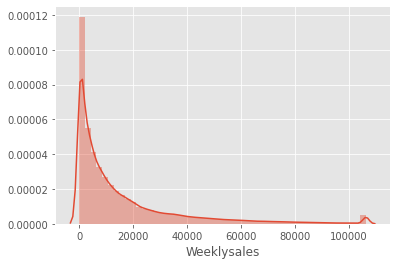

In [0]:
sns.distplot(data_train.Weeklysales)
plt.show()

In [0]:
#data_train['ln_weeklysales'] = np.log(data_train.Weeklysales)

In [0]:
#data_train.ln_weeklysales

#data_train.drop(columns = ['Weeklysales'], inplace = True)

In [0]:
#Correlation check.

data_train.corr()

,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2,Week_2.0,Week_3.0,Week_4.0,Week_5.0,Week_6.0,Week_7.0,Week_8.0,Week_9.0,Week_10.0,Week_11.0,Week_12.0,Week_13.0,Week_14.0,Week_15.0,Week_16.0,Week_17.0,Week_18.0,Week_19.0,Week_20.0,Week_21.0,Week_22.0,Week_23.0,...,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Store_21.0,Store_22.0,Store_23.0,Store_24.0,Store_25.0,Store_26.0,Store_27.0,Store_28.0,Store_29.0,Store_30.0,Store_31.0,Store_32.0,Store_33.0,Store_34.0,Store_35.0,Store_36.0,Store_37.0,Store_38.0,Store_39.0,Store_40.0,Store_41.0,Store_42.0,Store_43.0,Store_44.0,Store_45.0,IsHoliday_train_True,IsHoliday_features_True,Type_B,Type_C
Dept,1.000000,0.142971,0.004381,0.003514,-0.002304,-0.000508,-0.003233,0.002887,-0.000914,-0.007483,0.007874,-0.003022,0.003688,0.000894,0.004381,0.004381,0.003518,0.003522,-0.000539,-0.000483,-0.000486,-0.000015,0.000589,0.000705,-0.000716,0.000166,-0.000093,-0.000853,-0.000915,-0.001120,-0.000670,-0.000301,-0.000622,-0.000911,0.000560,0.000510,-0.000119,-0.000037,0.000237,0.000399,...,-0.001165,0.001544,-0.004009,0.001893,-0.001196,-0.001190,-0.007956,-0.003393,-0.003886,0.003396,-0.000853,-0.006279,-0.003112,-0.001569,0.001034,-0.003483,0.000080,0.001066,0.001041,-0.005346,0.012066,0.001478,0.001229,0.009906,0.002503,-0.003760,0.011676,0.011394,0.008696,0.002376,0.002551,0.002906,0.011724,0.011874,0.010706,-0.004361,0.000906,0.000906,-0.029920,0.028344
Weeklysales,0.142971,1.000000,0.000733,0.001395,0.064837,0.007342,-0.000168,0.034845,0.085459,-0.022697,-0.025362,0.252562,-0.009344,0.025600,0.000793,0.000774,0.001336,0.001360,-0.010779,-0.010363,-0.013125,-0.000319,0.002487,0.003790,-0.005334,-0.000897,-0.002985,-0.003110,-0.006309,-0.001178,0.004083,-0.003280,-0.001829,-0.006844,0.000973,-0.002430,-0.002875,0.001159,0.006222,0.003886,...,0.075430,0.026728,-0.006437,0.078103,0.083533,-0.049927,-0.056780,-0.020252,-0.000026,0.033911,0.091517,-0.032460,-0.004160,0.029859,0.023058,-0.039842,-0.008612,0.062923,0.021545,-0.054871,-0.043568,0.027583,0.004836,-0.059711,-0.016253,-0.014898,-0.041638,-0.033995,-0.052361,0.038002,-0.014445,0.015811,-0.026257,-0.013748,-0.060857,-0.029650,0.007922,0.007922,-0.134941,-0.098980
Temperature,0.004381,0.000733,1.000000,0.142258,-0.009002,-0.202048,-0.016639,0.000549,-0.038839,0.184320,0.095296,-0.058823,0.066430,0.234949,0.999113,0.998226,0.142248,0.142237,-0.164263,-0.142830,-0.142440,-0.189708,-0.202487,-0.156796,-0.145728,-0.131139,-0.106665,-0.064387,-0.065036,-0.060871,-0.028725,-0.022717,-0.011285,0.002234,0.013724,0.022799,0.038408,0.080405,0.101952,0.104619,...,0.104051,0.105579,0.082632,-0.056665,-0.019773,-0.070837,-0.123851,-0.114890,-0.057442,-0.067913,-0.040964,0.072112,-0.044000,-0.095419,-0.052806,-0.067393,-0.136548,-0.024105,0.084619,-0.043395,0.062260,0.074744,-0.063562,0.109194,-0.014603,-0.023268,0.074286,0.080290,0.073459,0.088715,-0.105026,-0.100026,0.085917,0.061086,-0.044548,-0.019631,-0.156556,-0.156556,-0.108191,0.135782
Fuel_Price,0.003514,0.001395,0.142258,1.000000,0.017492,-0.116462,-0.449623,-0.052479,-0.086918,-0.162609,-0.034938,0.004468,0.780315,-0.042186,0.141900,0.141542,0.999567,0.999135,-0.031312,-0.025770,-0.022133,-0.082467,-0.076055,-0.068531,-0.059857,-0.027049,-0.001793,0.014141,0.019403,0.028756,0.046020,0.063838,0.069582,0.071809,0.079961,0.078847,0.070922,0.051259,0.033319,0.022090,...,0.070822,-0.047134,0.080651,-0.026481,0.019665,0.074274,-0.036938,-0.024351,0.028450,0.074754,0.020192,-0.046927,0.027146,0.028647,0.075742,0.019536,0.028356,0.075856,0.082118,0.027118,-0.038584,-0.048461,-0.041332,0.060421,-0.050481,0.019431,-0.039584,-0.036512,0.072845,-0.047630,0.028457,-0.039641,0.062982,-0.039610,-0.019040,0.019714,-0.077839,-0.077839,0.037372,0.001369
MarkDown1,-0.002304,0.064837,-0.009002,0.017492,1.000000,0.063718,-

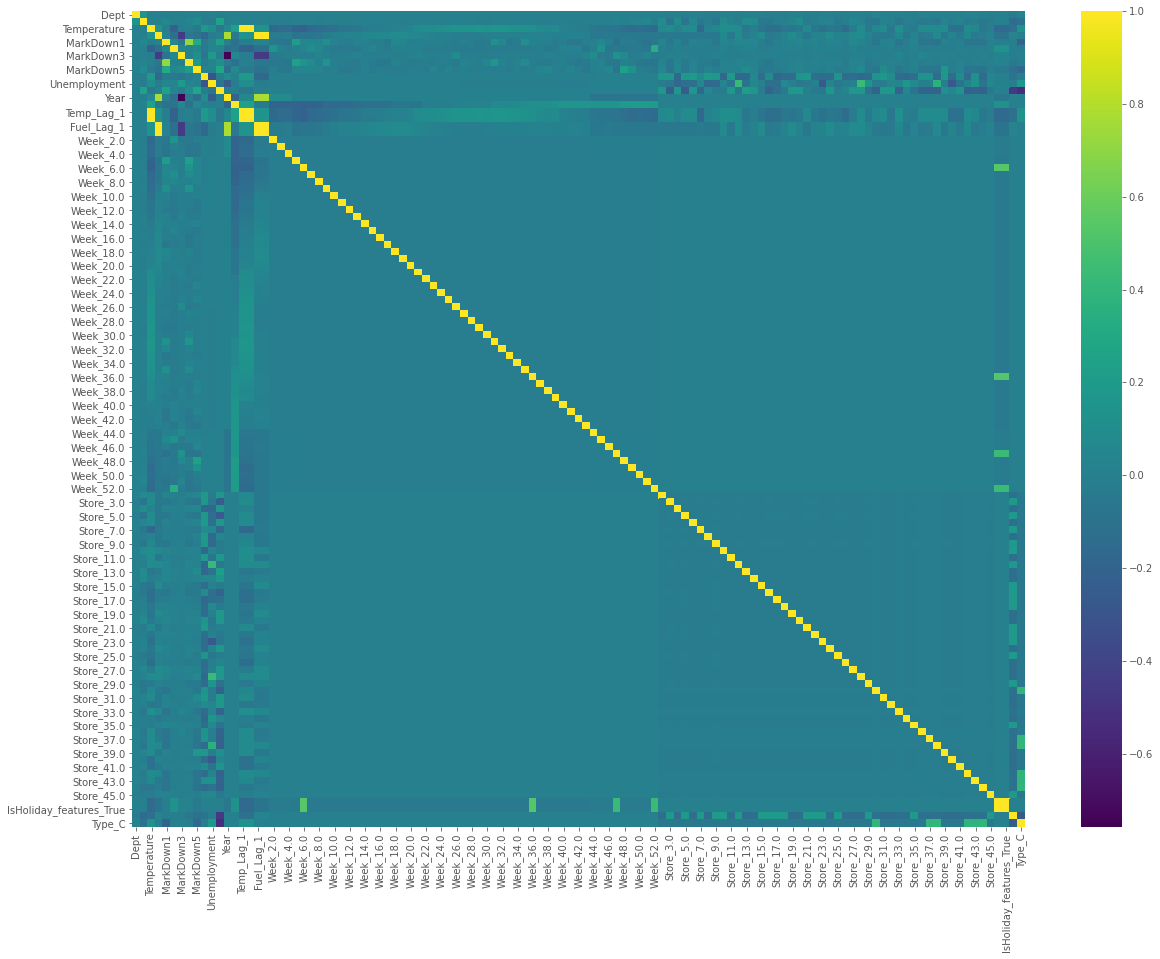

In [0]:
plt.subplots(figsize=(20, 15))
sns.heatmap(data_train.corr(), cmap="viridis")
plt.show()

## Dropping columns based on data summarisation and exploratory analysis.

    - Based on low variance (near zero variance, can be seen in the correlation matrix and heat map.)
    - High missings.
    - High correlations between two numerical variables and removing variables which are not important for business context.

In [0]:
data_train.drop(columns = ['IsHoliday_features_True'], inplace = True)
data_test.drop(columns = ['IsHoliday_features_True'], inplace = True)

#Columns have been deleted already, hence that error.

## Feature Selection using RFE

Based on my selecting the best features, the model has given a poor score with 30 variables so increasing the variables.

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

feature_columns = data_train.columns.difference(['ln_weeklysales'])

linreg = LinearRegression(n_jobs=-1)

rfe = RFE(linreg, n_features_to_select = 80, verbose=10)

rfe.fit(data_train[feature_columns], data_train['ln_weeklysales'])

print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting esti

In [0]:
X_final = data_train
y_final = data_train.Weeklysales


X_final.head()

,Dept,Weeklysales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Temp_Lag_1,Temp_Lag_2,Fuel_Lag_1,Fuel_Lag_2,Week_2.0,Week_3.0,Week_4.0,Week_5.0,Week_6.0,Week_7.0,Week_8.0,Week_9.0,Week_10.0,Week_11.0,Week_12.0,Week_13.0,Week_14.0,Week_15.0,Week_16.0,Week_17.0,Week_18.0,Week_19.0,Week_20.0,Week_21.0,Week_22.0,Week_23.0,...,Store_9.0,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Store_21.0,Store_22.0,Store_23.0,Store_24.0,Store_25.0,Store_26.0,Store_27.0,Store_28.0,Store_29.0,Store_30.0,Store_31.0,Store_32.0,Store_33.0,Store_34.0,Store_35.0,Store_36.0,Store_37.0,Store_38.0,Store_39.0,Store_40.0,Store_41.0,Store_42.0,Store_43.0,Store_44.0,Store_45.0,IsHoliday_train_True,Type_B,Type_C
0,1,24924.50,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,15.605590,15.605591,3.361025,3.361024,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,50605.27,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,15.605591,2.572000,3.361024,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,13740.12,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,5.727778,2.572000,2.572000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,39954.04,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,5.727778,2.572000,2.572000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,32229.38,5.727778,2.572,7246.420196,3374.762142,1442.141105,3383.168256,4628.975079,211.096358,8.106,151315,2010,2,5.727778,5.727778,2.572000,2.572000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Selecting significant variables

feature = data_train.columns
model_param = 'Weeklysales ~ ' + ' + '.join(feature)

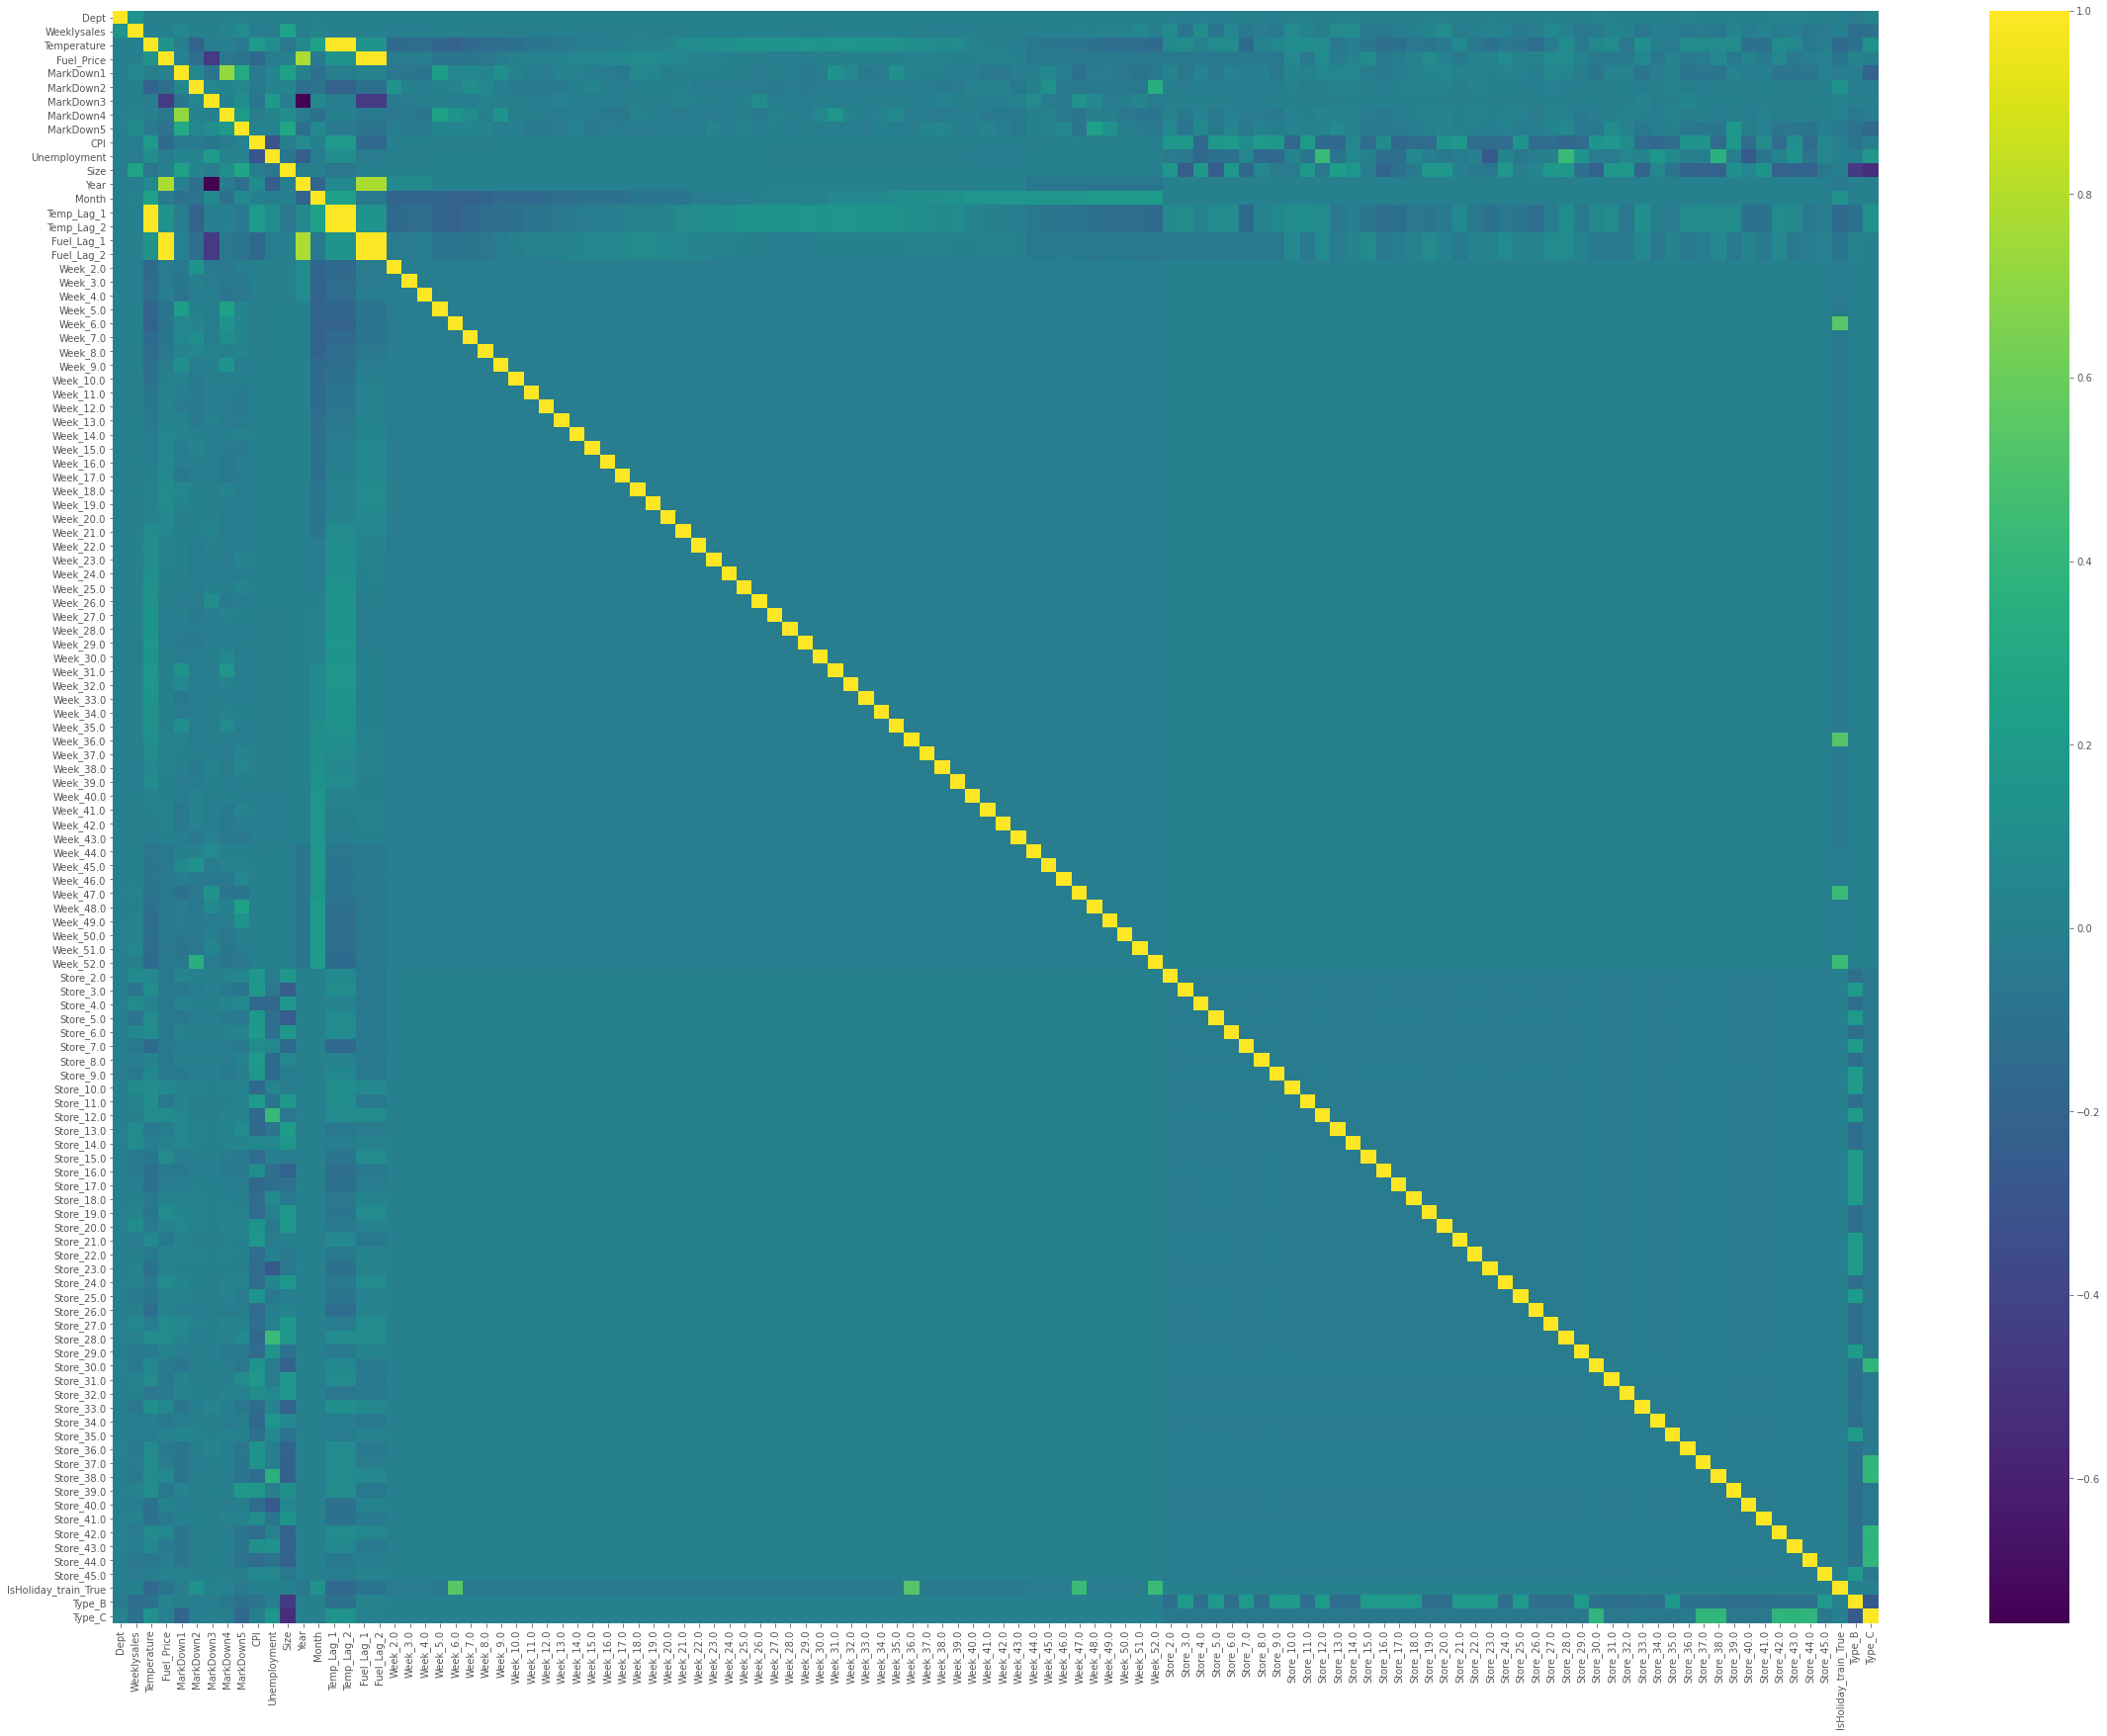

In [0]:
#Corelation check of the new variables
from google.colab import files

corr = X_final.corr()

#corr.to_excel('corr.xlsx')
#files.download('corr.xlsx')

plt.subplots(figsize=(40, 30))
sns.heatmap(X_final.corr(), cmap="viridis", annot=False)
plt.show()

## Building model from statsmodels

In [0]:
# method 2: divide the data into training and testing for statsmodels.formula.api
train, test = train_test_split(data_train, test_size = 0.3, random_state = 12345)

In [0]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  295099  |  No of obs in testing:  126471


In [0]:
import statsmodels.formula.api as smf

feature = data_train.columns
model_param = 'Weeklysales ~ ' + ' + '.join(feature)
model_param

'Weeklysales ~ Dept + Weeklysales + Temperature + Fuel_Price + MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + CPI + Unemployment + Size + Year + Month + Temp_Lag_1 + Temp_Lag_2 + Fuel_Lag_1 + Fuel_Lag_2 + Week_2.0 + Week_3.0 + Week_4.0 + Week_5.0 + Week_6.0 + Week_7.0 + Week_8.0 + Week_9.0 + Week_10.0 + Week_11.0 + Week_12.0 + Week_13.0 + Week_14.0 + Week_15.0 + Week_16.0 + Week_17.0 + Week_18.0 + Week_19.0 + Week_20.0 + Week_21.0 + Week_22.0 + Week_23.0 + Week_24.0 + Week_25.0 + Week_26.0 + Week_27.0 + Week_28.0 + Week_29.0 + Week_30.0 + Week_31.0 + Week_32.0 + Week_33.0 + Week_34.0 + Week_35.0 + Week_36.0 + Week_37.0 + Week_38.0 + Week_39.0 + Week_40.0 + Week_41.0 + Week_42.0 + Week_43.0 + Week_44.0 + Week_45.0 + Week_46.0 + Week_47.0 + Week_48.0 + Week_49.0 + Week_50.0 + Week_51.0 + Week_52.0 + Store_2.0 + Store_3.0 + Store_4.0 + Store_5.0 + Store_6.0 + Store_7.0 + Store_8.0 + Store_9.0 + Store_10.0 + Store_11.0 + Store_12.0 + Store_13.0 + Store_14.0 + Store_15.0 + Stor

In [0]:
#lm1 = smf.ols(model_param, train).fit()

In [0]:
#print(lm1.summary())

In [0]:
y_final = y_final.values.reshape(-1,1)

In [0]:
y_final

array([[24924.5 ],
       [50605.27],
       [13740.12],
       ...,
       [56017.47],
       [ 6817.48],
       [ 1076.8 ]])

### The model has performed very poorly as the dataset does not follow the assumptions of Linear Regression.

# Build the Model

We will be standardising the data as ANN's work very efficently with standardised data.
Standardizing the data generally speeds up learning and leads to faster convergence.
Also standardising the data is generally good practice.

## Modelling and Predictions

In [0]:
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X_final, y_final,test_size = 0.3, random_state = 12345)

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

feature_columns = data_train.columns.difference(['ln_weeklysales'])

linreg = LinearRegression(n_jobs=-1)

rfe = RFE(linreg, n_features_to_select = 80, verbose=10)

rfe.fit(data_train[feature_columns], data_train['ln_weeklysales'])

print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting esti

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

feature_columns = data_train.columns.difference(['ln_weeklysales'])

linreg = LinearRegression(n_jobs=-1)

rfe = RFE(linreg, n_features_to_select = 80, verbose=10)

rfe.fit(data_train[feature_columns], data_train['ln_weeklysales'])

print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting esti

In [0]:
linreg.fit(train_X,train_y)

NameError: ignored

In [0]:
linreg.score(train_X,train_y)

0.12709514155824275

In [0]:
linreg.intercept_

array([0.00055322])

In [0]:
linreg.predict(test_X)

array([[-0.00970069],
       [-0.66595069],
       [-0.46233741],
       ...,
       [-0.83410885],
       [-0.55316403],
       [-0.04022457]])

In [0]:
y_pred = pd.DataFrame( { 'actual':  test_y,
                                'predicted': linreg.predict( test_X) } )

ValueError: ignored

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# a) accuracy metrics (a. MAE: Mean Absolute Error)
MAE_train = mean_absolute_error(y_pred.actual, y_pred.predicted)


# print the values of MAE for train and test
print('MAE of training data with Linear Regression: ', MAE_train)


In [0]:
# c) MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_train = mean_squared_error(y_pred.actual, y_pred.predicted)

print('RMSE of training data with Linear Regression: ', np.sqrt(MSE_train))

### We have a very poor Linear Regression score because the dataset does not follow any of the assumptions of Linear Regression

## Using Random Forests and Ensemble Learning

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rand = RandomForestRegressor()
rand.fit(train_X,train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
rand.score(train_X, train_y)

0.1423633161852147

In [0]:
y_pred_rand = pd.DataFrame( { 'actual':  test_y,
                                'predicted': rand.predict( test_X) } )

TypeError: ignored

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# a) accuracy metrics (a. MAE: Mean Absolute Error)
MAE_train = mean_absolute_error(y_pred_rand.actual, y_pred_rand.predicted)


# print the values of MAE for train and test
print('MAE of training data with Random Forests Regressor: ', MAE_train)

In [0]:
# c) MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_train = np.sqrt(mean_squared_error(y_pred_rand.actual, y_pred_rand.predicted))

print('RMSE of training data with  Random Forests Regressor: ', np.sqrt(MSE_train))

## Random Forest using Grid Search CV

In [0]:
#pargrid_rf = {'n_estimators': [80, 90, 100, 120, 150, 200,250],
 #                 'max_features': [ 6, 7, 8, 9]
  #                       ,'min_samples_leaf':[1,2,3]}

#gscv_rf = GridSearchCV(RandomForestRegressor(random_state = 12345),
 #                      pargrid_rf, 
  #                     cv = 10, 
   #                    verbose = 10, 
    #                   n_jobs= - 1 )

#gscv_rf.fit(train_X,train_y)

#Grid Search CV will take a lot of time so interrupted the process.

In [0]:
#gscv_rf.score(train_X, train_y)

In [0]:
#y_pred_randgs = pd.DataFrame( { 'actual':  test_y,
 #                             'predicted': gscv_rf.predict( test_X) } )

In [0]:
 #a) accuracy metrics (a. MAE: Mean Absolute Error)
#MAE_train = mean_absolute_error(y_pred_randgs.actual, y_pred_randgs.predicted)

#print the values of MAE for train and test
#print('MAE of training data with Random Forests Regressor: ', MAE_train)

In [0]:
#c) MSE: Mean squared Error and RMSE: Root Mean Square Error
#MSE_train = np.sqrt(mean_squared_error(y_pred_randgs.actual, y_pred_randgs.predicted))

#print('RMSE of training data with  Random Forests Regressor: ', np.sqrt(MSE_train))

## Using Artificial Neural Networks

In [0]:
import tensorflow as tf

In [0]:
ann = tf.keras.models.Sequential()

In [0]:
# Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units = 8, kernel_initializer='normal', activation = 'relu'))

# Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))

# Adding the third hidden layer
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

In [0]:
#Compiling Neural Network
ann.compile(optimizer= 'adam', loss = 'mean_squared_error', metrics = ['mae','mse','acc'])

In [0]:
# Fitting our model 
ann.fit(train_X, train_y, batch_size = 10, epochs = 100)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29510/29510 [==============================] - 38s 1ms/step - loss: 0.9590 - mae: 0.7155 - mse: 0.9590 - acc: 0.0000e+00
Epoch 2/100
29510/29510 [==============================] - 39s 1ms/step - loss: 0.9565 - mae: 0.7137 - mse: 0.9565 - acc: 0.0000e+00
Epoch 3/100
29510/29510 [==============================] - 37s 1ms/step - loss: 0.9561 - mae: 0.7133 - mse: 0.9561 - acc: 0.0000e+00
Epoch 4/100
29510/29510 [==============================] - 38s 1ms/step - loss: 0.9557 - mae: 0.7131 - mse: 0

In [0]:
score = ann.evaluate(train_X.values, train_y.values,
                            batch_size=10)
print('Test score:', score)

29510/29510 [==============================] - 31s 1ms/step - loss: 0.9559 - mae: 0.7075 - mse: 0.9559 - acc: 0.0000e+00
Test score: [0.955886721611023, 0.7075479626655579, 0.955886721611023, 0.0]


In [0]:
ann.metrics_names

['loss', 'mae', 'mse', 'acc']

In [0]:
ann.predict(test_X)

array([[0.14100005],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [0]:
# Step 4: predict the spend on the training data

train_X['pred_spend_ann']= ann.predict(train_X)
#train_X.drop(columns = ['pred_spend_ann'], inplace = True)

# Step 5: predict the spend on the testing/validation data

test_X['pred_spend_ann'] = ann.predict(test_X)
#test_X.drop(columns = ['pred_spend_ann'], inplace = True)

#rand_score = pd.Series(rand.predict(test_X))
#Converting numpy array to Series.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
pd.concat([train_y,train_X['pred_spend_ann']], axis = 1)

,0,pred_spend_ann
174852,-1.001559,0.104192
107425,0.141700,0.290679
194045,1.501518,0.643413
271012,0.729783,0.224936
297788,-0.176739,0.145784
...,...,...
347556,0.761249,0.000000
395393,-1.267312,0.000000
392477,-2.245324,0.000000
77285,0.515992,0.126528


In [0]:
pd.concat([test_y,test_X['pred_spend_ann']], axis = 1)

,0,pred_spend_ann
331445,1.086464,0.141000
342761,1.133304,0.000000
47088,-0.228262,0.000000
162498,0.390365,0.054744
104164,-0.246878,0.358231
...,...,...
276944,1.268554,0.298492
148043,-0.504015,0.000000
404816,-0.840734,0.000000
347479,0.905414,0.000000


In [0]:
# a) accuracy metrics (a. MAE: Mean Absolute Error)
from sklearn.metrics import mean_absolute_error, mean_squared_error
MAE_train = mean_absolute_error(train_y, train_X.pred_spend_ann)
MAE_test = mean_absolute_error(test_y, test_X.pred_spend_ann)

# print the values of MAE for train and test
print('MAE of training data with Linear Regression: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data with Linear Regression:  0.7075467641837463  |  MAE of testing data:  0.7090853725930719


In [0]:
# b) MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_train = mean_squared_error(train_y, train_X.pred_spend_ann)
MSE_test = mean_squared_error(test_y, test_X.pred_spend_ann)

# print the values of MSE for train and test
print('MSE of training data with Linear Regression: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data with Linear Regression: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data with Linear Regression:  0.9558908660044557  |  MSE of testing data:  0.9618221201724932
RMSE of training data with Linear Regression:  0.9776967147354315  |  RMSE of testing data:  0.9807253031162667


## We discover that ANN give us the lowest MAE and RMSE so we will go ahead with that model.



In [0]:
#test_X.drop(columns = ['Predictions'], inplace = True) #Removing the Predicted column as it was made by mistake.

In [0]:
# Step 4: predict the spend on the training data

#I have removed the 0 column so I can add the prediction column. This is only to concatenate all the prediction values.
#train_X.drop(columns = [0], inplace = True)
#test_X.drop(columns = [0], inplace = True)

train_X['pred_spend_rf']= rand.predict(train_X)

# Step 5: predict the spend on the testing/validation data

test_X['pred_spend_rf'] = rand.predict(test_X)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [0]:
# a) accuracy metrics (a. MAE: Mean Absolute Error)
MAE_train = mean_absolute_error(train_y, train_X.pred_spend_rf)
MAE_test = mean_absolute_error(test_y, test_X.pred_spend_rf)

# print the values of MAE for train and test
print('MAE of training data with Linear Regression: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data with Linear Regression:  18209.246388162126  |  MAE of testing data:  18142.394487711674


In [0]:
# b) MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_train = mean_squared_error(train_y, train_X.pred_spend_rf)
MSE_test = mean_squared_error(test_y, test_X.pred_spend_rf)

# print the values of MSE for train and test
print('MSE of training data with Linear Regression: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data with Linear Regression: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data with Linear Regression:  734410506.3127159  |  MSE of testing data:  728560431.6081623
RMSE of training data with Linear Regression:  27100.009341561414  |  RMSE of testing data:  26991.858617149028


In [0]:
# d.1) Corelation between actual and predicted
Corr_train = stats.pearsonr(test_y, test_X.pred_spend_ann)

# print the values of Corelation.
print('Corr of training data: ', Corr_train)

Corr of training data:  (0.6832651784902459, 0.0)


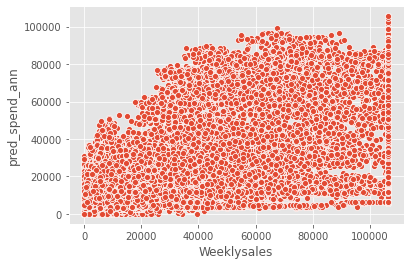

In [0]:
# d.2) Corelation between actual and predicted

sns.scatterplot(test_y, test_X.pred_spend_ann)
plt.show()

## Predictions using ANN on original Train data

In [0]:
from google.colab import files

train_predict = pd.concat([train_y,train_X['pred_spend_ann'],train_X['pred_spend_rf']], axis = 1)
#train_predict.to_excel('train_predict.xlsx')
#files.download('train_predict.xlsx')

In [0]:
test_predict = pd.concat([test_y,test_X['pred_spend_ann'],test_X['pred_spend_rf']], axis = 1)
#test_predict.to_excel('test_predict.xlsx')
#files.download('test_predict.xlsx')

In [0]:
#data_test.rename(columns= {'IsHoliday_test_True': 'IsHoliday_train_True'}, inplace = True )
#test_data.drop(columns = ['Predictions_RF'])
test_data = data_test[features_final]

In [0]:
#test_data.drop(columns = ['Predictions_ann'], inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
test_data['Predictions_rf'] = rand.predict(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
test_data.head()

,CPI,Dept,Fuel_Lag_1,IsHoliday_train_True,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Month,Size,Store,Type_B,Type_C,Unemployment,Year,Predictions_rf
0,223.462779,1,3.581544,0,6766.44,5147.7,50.82,3639.9,2737.42,11,151315,1,0,0,6.573,2012,15007.033700
1,223.462779,2,3.386000,0,6766.44,5147.7,50.82,3639.9,2737.42,11,151315,1,0,0,6.573,2012,6327.436385
2,223.462779,3,3.386000,0,6766.44,5147.7,50.82,3639.9,2737.42,11,151315,1,0,0,6.573,2012,6327.436385
3,223.462779,4,3.386000,0,6766.44,5147.7,50.82,3639.9,2737.42,11,151315,1,0,0,6.573,2012,6327.436385
4,223.462779,5,3.386000,0,6766.44,5147.7,50.82,3639.9,2737.42,11,151315,1,0,0,6.573,2012,6327.436385


In [0]:
from google.colab import files

test_data.to_excel('Test Data with Predictions.xlsx')
files.download('Test Data with Predictions.xlsx')

KeyboardInterrupt: ignored

In [0]:
from google.colab import files

train_data = data_train[features_final]
train_data['Predictions_rand'] = rand.predict(train_data)

train_data.to_excel('Train Data with Predictions.xlsx')
files.download('Train Data with Predictions.xlsx')

NameError: ignored

In [0]:
train_data = pd.concat([train_data, data_train.Weeklysales], axis = 1)

## Decile Analysis

In [0]:
# Step: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train_data['Deciles'] = pd.qcut(train_data['Predictions_rand'], 10, labels = False)

# Decile Analysis for train_data data
Predicted_avg = train_data[['Deciles', 'Predictions_rand']].groupby(train_data.Deciles).mean().sort_index(ascending = False)['Predictions_rand']
Actual_avg = train_data[['Deciles', 'Weeklysales']].groupby(train_data.Deciles).mean().sort_index(ascending = False)['Weeklysales']
Decile_analysis_train_data = pd.concat([Actual_avg, Predicted_avg], axis = 1).reset_index()


# write the data into the file
Decile_analysis_train_data.to_csv('Decile_analysis_train.csv')

NameError: ignored

In [0]:
Decile_analysis_train_data